# 661 VGS Financial Year 2024-2025

In [1]:
# Load data from MongoDB.
# Import modules.
import sys
import os
import altair as alt
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

# User defined modules.
# Ensure the src directory is in the sys.path.
src_path = Path.cwd().parent.resolve() / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from log_keeper.get_config import DbUser, Client, Database
from dashboard.utils import date_filter

# Load environment variables from .env file.
load_dotenv()

# CONSTANTS.
DB_NAME = "661vgs"

# Connect to the database.
db_user = DbUser(
    username=os.getenv('DASHBOARD_USERNAME'),
    password=os.getenv('DASHBOARD_PASSWORD'),
    uri=os.getenv('MONGO_URI')
)
client = Client(db_user=db_user)
if client.log_in():
    # Get the database.
    db = Database(
        client=client,
        database_name=DB_NAME
    )
    launches_df = db.get_launches_dataframe()

25-04-04 16:58:25 get_config.py INFO: Logged in to DB.
25-04-04 16:58:25 get_config.py INFO: User can access: ['661vgs', 'cgs']
25-04-04 16:58:25 get_config.py INFO: Collection log_sheets fetched.


In [2]:
# Wranging.
# Sort by date.
launches_df.sort_values(by='TakeOffTime', ascending=False, inplace=True)

# Convert categories to categorical types.
launches_df['Duty'] = launches_df['Duty'].astype('category')
launches_df['SPC'] = launches_df['SPC'].astype('category')
launches_df['Aircraft'] = launches_df['Aircraft'].astype('category')

# P1 and P2 should be boolean.
launches_df['P1'] = launches_df['P1'].astype('bool')
launches_df['P2'] = launches_df['P2'].astype('bool')
launches_df

,_id,AircraftCommander,SecondPilot,Duty,TakeOffTime,LandingTime,FlightTime,SPC,PLF,Aircraft,Date,P1,P2
4757,67e965566d4ad809da0843b6,Gallagher,Robertson,PAX,2025-03-30 16:30:00,2025-03-30 16:34:00,4,1,False,ZE602,2025-03-30,False,False
4743,67e965566d4ad809da0843b5,Burton,Kane,GIF,2025-03-30 16:17:00,2025-03-30 16:23:00,6,1,False,ZE495,2025-03-30,False,False
4756,67e965566d4ad809da0843b4,Gallagher,Nugent,PAX,2025-03-30 16:09:00,2025-03-30 16:15:00,6,1,False,ZE602,2025-03-30,False,False
4751,67e965566d4ad809da0843b3,Burton,Kane,GIF,2025-03-30 15:53:00,2025-03-30 15:58:00,5,1,False,ZE495,2025-03-30,False,False
4742,67e965566d4ad809da0843b2,Gallagher,Baruah,PAX,2025-03-30 15:40:00,2025-03-30 15:55:00,15,6,False,ZE602,2025-03-30,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,6712d6cd0a2e5c357b2ca371,Lewis,Abbott,SCT QGI,2023-02-25 11:48:00,2023-02-25 11:50:00,2,1,True,ZE495,2023-02-25,True,True
4097,6712d6cd0a2e5c357b2ca370,Lewis,Abbott,SCT QGI,2023-02-25 11:24:00,2023-02-25 11:30:00,6,1,False,ZE495,2023-02-25,True,True
4096,6712d6cd0a2e5c357b2ca36f,Jennings,Cuthell,G/S,2023-02-25 10:51:00,2023-02-25 10:57:00,6,1,False,ZE495,2023-02-25,True,True
4095,6712d6cd0a2e5c357b2ca36e,Jennings,Cuthell,G/S,2023-02-25 10:33:00,2023-02-25 10:38:00,5,1,False,ZE495,2023-02-25,True,True


## Summary

In [5]:
# Filter all launches > April 2023
launches_df = launches_df[
    launches_df['TakeOffTime'] > pd.to_datetime("2023-04-01")
].reset_index(drop=True)

# Add a financial year column
launches_df['FinancialYear'] = launches_df['Date'].apply(
    lambda x: f"{x.year - 1}-{x.year}" if x.month < 4 else f"{x.year}-{x.year + 1}"
)

25-04-04 16:59:19 category.py INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
25-04-04 16:59:19 category.py INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


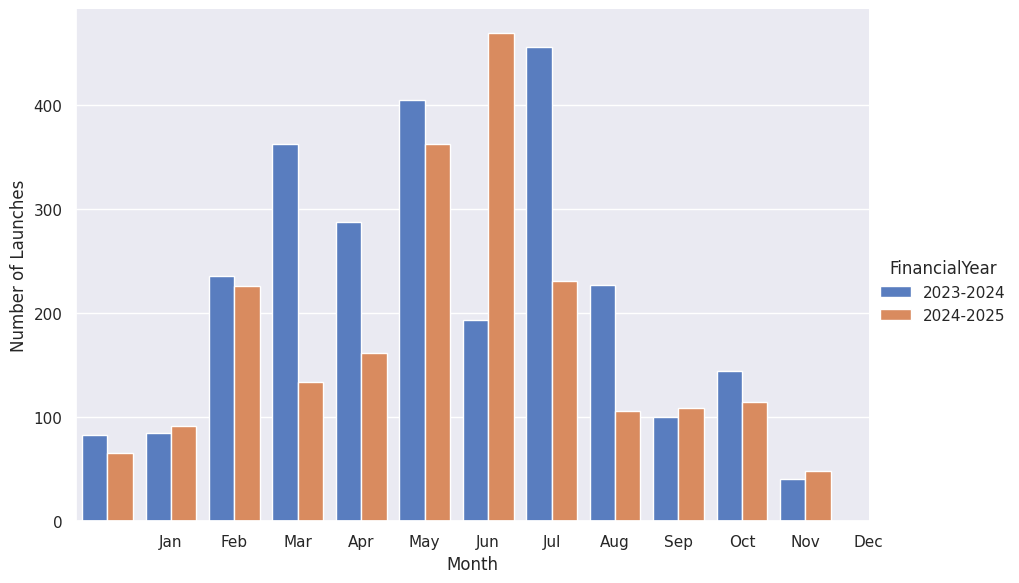

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in Jupyter Notebook
%matplotlib inline

# Group launches by month and financial year
launches_by_month = launches_df.groupby(['FinancialYear', launches_df['Date'].dt.month]).size().reset_index(name='Launches')
launches_by_month.rename(columns={'Date': 'Month'}, inplace=True)
launches_by_month['FinancialYear'] = pd.Categorical(
    launches_by_month['FinancialYear'],
    categories=sorted(launches_by_month['FinancialYear'].unique(), key=lambda x: int(x.split('-')[0])),
    ordered=True
)

# Create a bar plot using seaborn with a different color theme
sns.set_theme(style="darkgrid", palette="muted")
g = sns.catplot(
    data=launches_by_month,
    x="Month",
    y="Launches",
    hue="FinancialYear",
    kind="bar",
    height=6,
    aspect=1.5
)

# Set plot labels and title
g.set_axis_labels("Month", "Number of Launches")
g.set_titles("Launches by Financial Year Compared")
g.set(xticks=range(1, 13), xticklabels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.show()

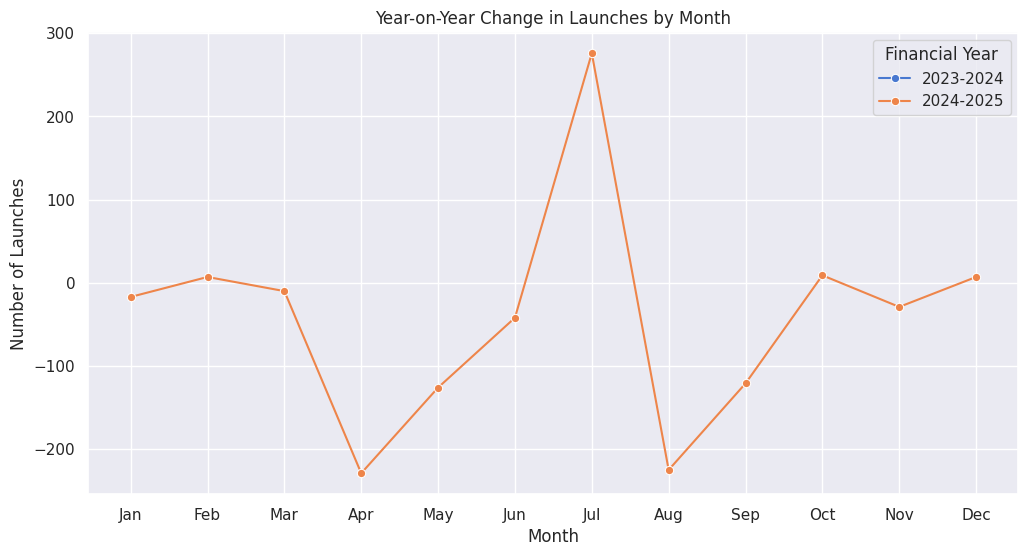

In [7]:
# Calculate the year-on-year change in launches
launches_by_month['YoYChange'] = launches_by_month.groupby('Month')['Launches'].diff()

# Create a line plot to show year-on-year change
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=launches_by_month,
    x="Month",
    y="YoYChange",
    hue="FinancialYear",
    marker="o"
)

# Set plot labels and title
plt.title("Year-on-Year Change in Launches by Month")
plt.xlabel("Month")
plt.ylabel("Number of Launches")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="Financial Year")
plt.grid(True)
plt.show()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
